<h2><b>Robot Trading – Juan Carlos López Borda</b></h2>

<img src="https://raw.githubusercontent.com/JuanC-Pythonista/Robot_Trading/main/Media/bitcoin.jpg" alt="">

In [3]:
#Se importan librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from bs4 import BeautifulSoup
import requests
import scipy.stats as stats
import seaborn as sns
from IPython.display import clear_output
import time

<h3><b>1. Configuración del ambiente</b></h3>


In [2]:
# Versiones
!python -V
print('------')
!pip freeze | findstr pandas
print('------')
!pip freeze | findstr numpy
print('------')
!pip freeze | findstr matplotlib

Python 3.10.6
------
geopandas==0.12.2
pandas==1.5.2
------
numpy==1.23.5
------
matplotlib==3.6.2
matplotlib-inline==0.1.6


<h3><b>2. Obtención de datos</b></h3>


In [4]:
# Se obtienen los datos por medio de yfinance de los valores del Bitcoin en un periodo de 7dias 
def importar_base_bitcoin():        
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    ticker = "BTC-USD" 
    df_bitcoin=yf.Ticker(ticker).history(period="7d",interval="5m")    
    return df_bitcoin

In [5]:
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-15 00:00:00+00:00,26931.384766,26940.218750,26927.855469,26939.564453,0,0.0,0.0
2023-05-15 00:05:00+00:00,26942.525391,26942.525391,26920.029297,26920.029297,0,0.0,0.0
2023-05-15 00:10:00+00:00,26918.232422,26935.404297,26914.136719,26935.404297,0,0.0,0.0
2023-05-15 00:15:00+00:00,26919.871094,26919.871094,26811.279297,26812.771484,90236928,0.0,0.0
2023-05-15 00:20:00+00:00,26818.732422,26837.500000,26808.048828,26834.156250,38383616,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-21 02:30:00+00:00,27168.851562,27174.070312,27168.851562,27174.070312,9605120,0.0,0.0
2023-05-21 02:35:00+00:00,27174.912109,27180.109375,27174.912109,27180.109375,1551360,0.0,0.0
2023-05-21 02:40:00+00:00,27181.472656,27181.472656,27179.666016,27179.666016,7379968,0.0,0.0


In [49]:
# Se extraen los datos de la página coinmarketcap mediante la librería BeautifulSoup
def extraer_tendencias():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    url = "https://coinmarketcap.com/"
    respuesta = requests.get(url)
    bs=BeautifulSoup(respuesta.content, features="lxml")
    div_precio = bs.find("div", class_="sc-cadad039-0 clgqXO")
    span_precio = div_precio.find("span")
    precio_actual = float(span_precio.text.replace("$", "").replace(',',''))
    #------------------------------------------------------
    div_variacion = bs.find("span", class_=['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS'])       
    variacion = div_variacion.text
    #-----------------------------------------------------------
    div_tendencia=str(bs.find('span',{'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']}))
    if "icon-Caret-down" in div_tendencia:
        tendencia = "Baja"
    elif "icon-Caret-up" in div_tendencia:
        tendencia = "Alta"
    else:
        tendencia = "not found"   
    return[precio_actual,variacion,tendencia]

In [50]:
extraer_tendencias()


[27180.6, '0.03%', 'Alta']

<h3><b>3. Limpieza de datos</b></h3>



In [8]:
# Se realiza la limpieza de datos, se llenan los nulos con la media de los datos de la columna Close, 
# se filtra los Volume mayores a 0 y se filtra el DataSet con los valores de close filtrando los datos 
# atípicos mediante los cuartiles
def limpieza_datos():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    df_bitcoin_copia = df_bitcoin.copy() 
    df_bitcoin_limpio = df_bitcoin_copia[~df_bitcoin_copia.index.duplicated()]
    df_bitcoin_limpio.isnull().sum()
    mean_df = df_bitcoin_limpio['Close'].mean()
    df_bitcoin_limpio["Close"].fillna(mean_df, inplace = True)
    df_bitcoin_limpio = df_bitcoin_limpio.loc[df_bitcoin_limpio['Volume'] > 0]
    Q1 = df_bitcoin_limpio["Close"].quantile(q=.25)
    Q3 = df_bitcoin_limpio["Close"].quantile(q=.75)
    IQR = df_bitcoin_limpio["Close"].apply(stats.iqr)
    df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|
    media_bitcoin = df_bitcoin_limpio['Close'].mean()    
    return media_bitcoin

C:\Users\jlope\AppData\Local\Temp\ipykernel_17388\1624311993.py:15: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|


27119.209625632226


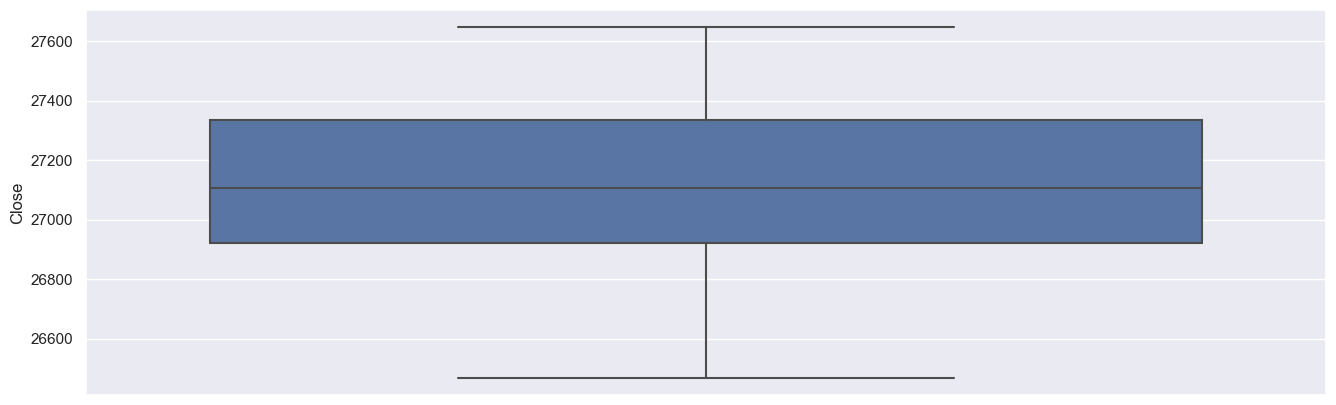

In [51]:
print(limpieza_datos())
outliers = sns.boxplot(y ="Close", data = df_bitcoin_limpio)

<h3><b>4. Tomar decisiones</b></h3>

In [10]:
#Se realiza un algoritmo mediante condiciones para tomar una decisión de Compra o Venta
def tomar_decisiones():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision,variacion,df_bitcoin_limpio
    if((precio_actual >= media_bitcoin) & (tendencia == "Baja")):
        algoritmo_decision = "Vender"
    elif((precio_actual < media_bitcoin) & (tendencia == "Alta")):
         algoritmo_decision = "Comprar"
    else:
         algoritmo_decision = "Tomando Decisión"
    return algoritmo_decision       

In [11]:
tomar_decisiones()

'Vender'

<h3><b>5. Visualización</b></h3>


In [12]:
# Se realiza un plot con la librería seaborn para evidenciar el comportamiento del Bitcoin para 
# realizar compraventa de activos
def visualizacion():
    #--------------------------------------------------------
    #--------------------------------------------------------
    if((precio_actual >= media_bitcoin) & (tendencia == "Baja")):
        color ='red'
    elif((precio_actual < media_bitcoin) & (tendencia == "Alta")):
        color ='green'
    else:
        color ='blue'   
     #-------------------------------------------------------
     #-------------------------------------------------------
    df_bitcoin['Promedio'] = media_bitcoin
    sns.set(rc={"figure.figsize":(16, 5)})
    ax = sns.lineplot(data=df_bitcoin, x=df_bitcoin.index, y=df_bitcoin["Close"])
    ax = sns.lineplot(data=df_bitcoin, x=df_bitcoin.index, y=df_bitcoin["Promedio"])    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title("Bitcoin Trading")
    ax.set(xlabel=None)
    ax.set(ylabel=None)    
    ax.annotate(tomar_decisiones(),(df_bitcoin.index[-1],df_bitcoin["Close"][-1]),arrowprops = dict(facecolor = color, shrink = 0.05),fontsize=14)
    plt.show()

C:\Users\jlope\AppData\Local\Temp\ipykernel_17388\2822872660.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


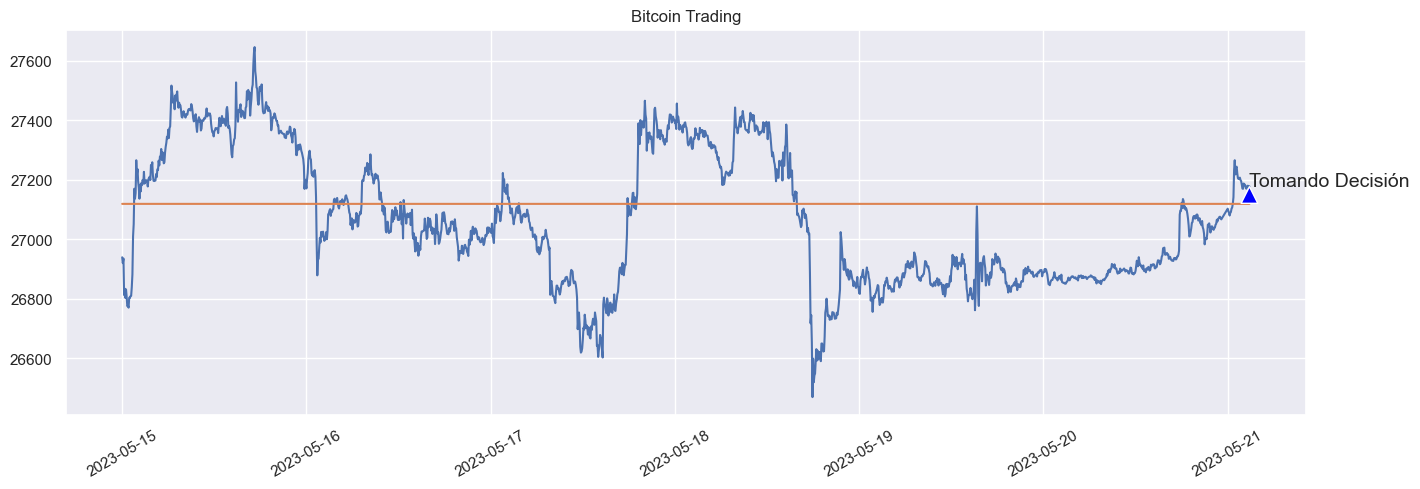

In [52]:
visualizacion()


<h3><b>6. Automatización</b></h3>


C:\Users\jlope\AppData\Local\Temp\ipykernel_14836\1624311993.py:15: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_bitcoin_limpio = df_bitcoin_limpio[~((df_bitcoin_limpio< (Q1-1.5*IQR)) & (df_bitcoin_limpio > (Q3+1.5*IQR)))]#|
C:\Users\jlope\AppData\Local\Temp\ipykernel_14836\2822872660.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


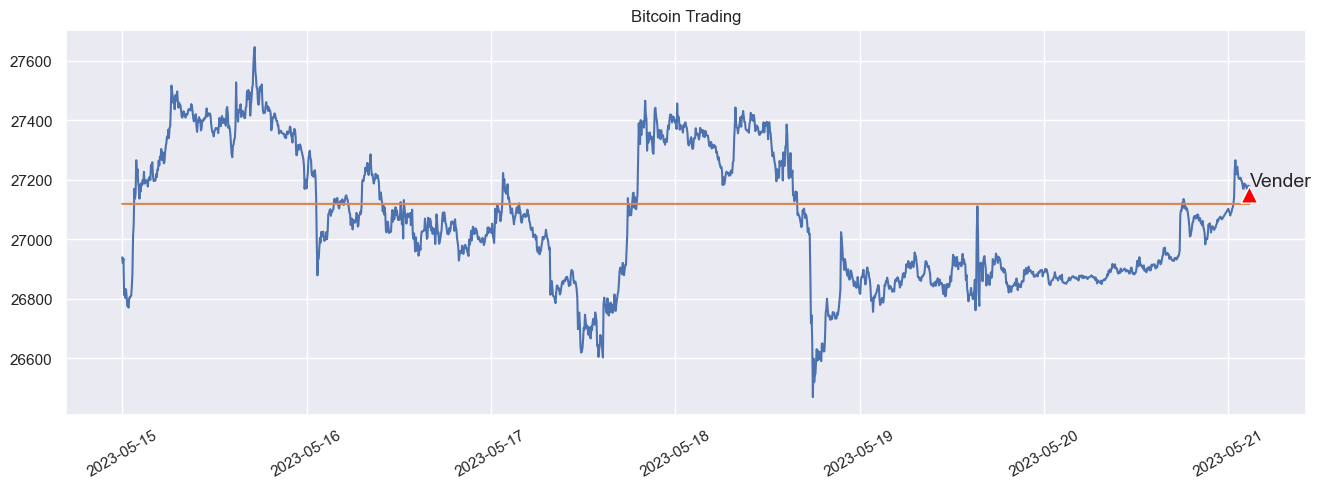

In [13]:
# Se automatiza el trading mediante un ciclo infinito while true que se renueva cada 5 minutos
while(True):
   clear_output()
   importar_base_bitcoin()
   extraer_tendencias()
   limpieza_datos()
   tomar_decisiones()
   visualizacion()
   time.sleep(300)